# Quantitative Biology Lab - Week 2
## Radhika Jangi

In [1]:
import matplotlib.pyplot as plt

### 1. bwa index for reference genome
> bwa index sacCer3.fa<br/>

Output is multiple files:
> sacCer3.fa.amb<br/>
> sacCer3.fa.ann<br/>
> sacCer3.fa.bwt<br/>
> sacCer3.fa.pac<br/>
> sacCer3.fa.sa

### 2. bwa mem for read alignment
bash script for aligning each reads file to reference genome

> #!/bin/bash<br/>
> for SAMPLE in 09 11 23 24 27 31 35 39 62 63<br/>
> do<br/>
>> bwa mem -R "@RG\tID:${SAMPLE}\tSM:{SAMPLE}"  sacCer3.fa A01_${SAMPLE}.fastq > A01_${SAMPLE}.sam<br/>

> done

### 3. sorted BAM file
bash script for turning each SAM file into a sorted BAM file

> #!/bin/bash<br/>

> for SAMPLE in 09 11 23 24 27 31 35 39 62 63<br/>
> do
	>> samtools view -S -b A01_${SAMPLE}.sam | samtools sort -o A01_${SAMPLE}.sorted.bam<br/>
    
> done 

### 4. freebayes
> freebayes -f sacCer3.fa output*.bam -p 1 --genotype-qualities > var.vcf

### 5. vcffilter
> cat var.vcf | vcffilter -f "QUAL > 20" > results.vcf

### 6. vcfallelicprimitives
> vcfallelicprimitives -k -g results.vcf > decomposed.vcf

### 7. snpeff
> snpeff download R64-1-1.86<br/>
> snpeff ann R64-1-1.86 decomposed.vcf > snpeff.vcf

### 8. plot

In [2]:
# Read in file
f = open("/Users/cmdb/qbb2020-answers/week2/snpeff.vcf", 'r')
snpeff = f.readlines()
f.close()

In [3]:
# Get GQ and DP values from each row in FORMAT column and store in lists
read_depths = []
geno_qual = []
for line in snpeff:
    if line.startswith('#'): # Toss header
        continue
    else:
        line = line.rsplit()
        info = line[9:-1] # Keep only FORMAT columns for each row
        for sublist in info:
            sub = sublist.split(':')
            if sub[1] == '.': # Toss empty entries
                continue
            else:
                geno_qual.append(float(sub[1])) # append genotype quality score to list
            if sub[2] == '.': # Toss empty entries
                continue
            else:
                read_depths.append(int(sub[2])) # append read depth to list

In [4]:
# Pull all AF values from INFO colum
allele_freq = []
for line in snpeff:
    if '#' in line: # Toss header lines
        continue
    else:
        find = line.find('AF=') # Find index of where 'AF=' starts
        AF_list = line[find+3:find+10] # Get whole number if multiple decimal places
        AF = AF_list.split(';')[0].split(',') # Keep only the allele frequency number
        allele_freq.append(AF) # Append to list

In [5]:
allele_freq = sum(allele_freq, []) # Flatten nested lists for multiple frequency instances
allele_freq = [float(i) for i in allele_freq] # Convert strings to floats

In [6]:
# Pull all ANN effects from INFO colum
ann_effects = []
for line in snpeff:
    if '#' in line: # Toss header lines
        continue
    else:
        find = line.find('ANN=') # Find index of where 'ANN=' starts
        ann_list = line[find:-1] # Annotation field goes till the end, so keep all of the column from that point
        ann = ann_list.split('\t')[0].split('|') # Split by multiple subfields

        effects = ann[1].split('&') # Split effects into separate strings
        ann_effects.append((effects)) # Append each effect

ann_effects = sum(ann_effects, []) # Flatten nested list

In [7]:
# Create dictionary of key = effect, value = frequency of effect for barplot
effect_count = {x:ann_effects.count(x) for x in ann_effects}
print(effect_count)

{'upstream_gene_variant': 16318, 'synonymous_variant': 15607, 'missense_variant': 9370, 'stop_gained': 76, 'splice_region_variant': 62, 'intron_variant': 13, 'stop_lost': 32, 'frameshift_variant': 160, 'disruptive_inframe_deletion': 21, 'downstream_gene_variant': 226, 'disruptive_inframe_insertion': 9, 'conservative_inframe_insertion': 10, 'stop_retained_variant': 28, 'initiator_codon_variant': 1, 'start_lost': 23, 'conservative_inframe_deletion': 6, 'non_coding_transcript_exon_variant': 1, '': 677, 'splice_donor_variant': 1, 'splice_acceptor_variant': 1}


In [8]:
# Drop empty effect from dictionary
effect_count.pop('')
print(effect_count)

{'upstream_gene_variant': 16318, 'synonymous_variant': 15607, 'missense_variant': 9370, 'stop_gained': 76, 'splice_region_variant': 62, 'intron_variant': 13, 'stop_lost': 32, 'frameshift_variant': 160, 'disruptive_inframe_deletion': 21, 'downstream_gene_variant': 226, 'disruptive_inframe_insertion': 9, 'conservative_inframe_insertion': 10, 'stop_retained_variant': 28, 'initiator_codon_variant': 1, 'start_lost': 23, 'conservative_inframe_deletion': 6, 'non_coding_transcript_exon_variant': 1, 'splice_donor_variant': 1, 'splice_acceptor_variant': 1}


In [9]:
# Sort dictionary and keys by value for nicer bar plot
sort_effect = {k: effect_count[k] for k in sorted(effect_count, key = effect_count.get, reverse = True)}
keys = sort_effect.keys()
values = sort_effect.values()

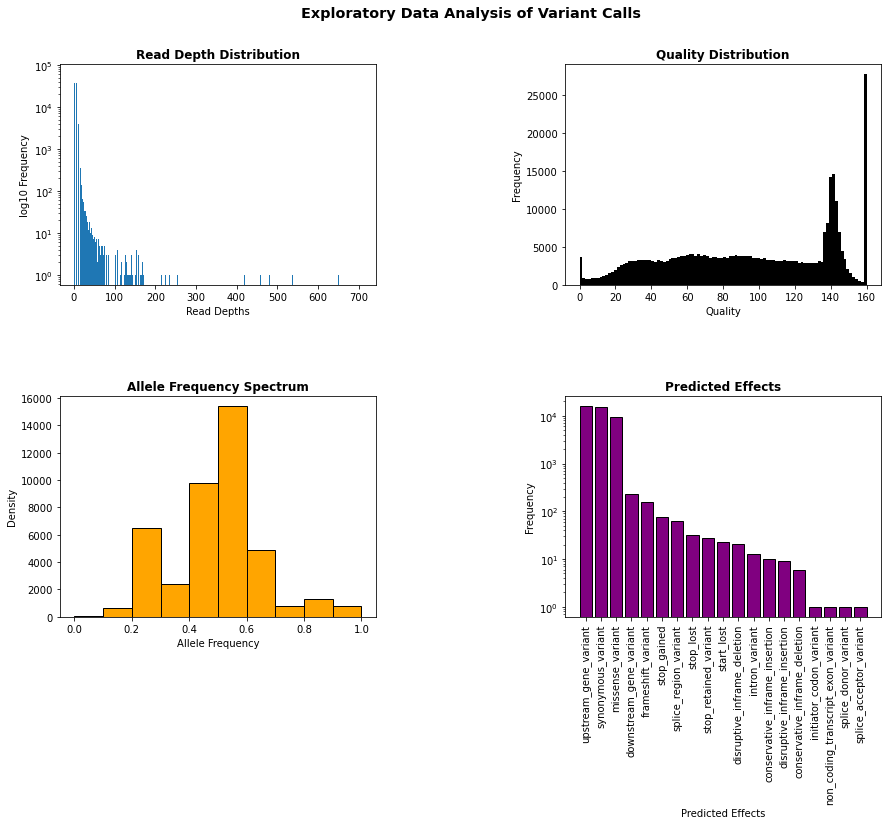

In [10]:
# Plot each variant identity as a subplot
plt.figure()
plt.suptitle('Exploratory Data Analysis of Variant Calls', y = 2.2, x = 1.05, size = 'x-large', weight = 'heavy')
plt.subplot(221)
plt.hist(read_depths, bins = 1000)
plt.title('Read Depth Distribution', weight = 'heavy')
plt.yscale('log')
plt.xlabel("Read Depths")
plt.ylabel("log10 Frequency")

plt.subplot(222)
plt.hist(geno_qual, bins = 100, color = ['black'])
plt.title('Quality Distribution', weight = 'heavy')
plt.xlabel("Quality")
plt.ylabel("Frequency")

plt.subplot(223)
plt.hist(allele_freq, bins = 10, color = ['orange'], edgecolor = "black", linewidth = 1)
plt.title('Allele Frequency Spectrum', weight = 'heavy')
plt.xlabel("Allele Frequency")
plt.ylabel("Density")

plt.subplot(224)
plt.bar(keys, values, color = ['purple'], edgecolor = "black", linewidth = 1)
plt.title('Predicted Effects', weight = 'heavy')
plt.xticks(rotation = 90)
plt.yscale('log')
plt.xlabel("Predicted Effects")
plt.ylabel("Frequency")
plt.subplots_adjust(top = 2, bottom = 0.08, left = 0.10, right = 2, hspace = 0.5,
                    wspace = 0.6)
plt.show()